## Part 2 - Clustering

Importing the required libraries and checking for the python version.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os
import cv2

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

Loading only the training dataset for Part 2 of the coursework

In [2]:
CW_DATASET_PATH = "CW_dataset"

def load_train_data(dataset_path=CW_DATASET_PATH):
    x_train_all_path = os.path.join(dataset_path, "x_train_all.csv")
    y_train_all_path = os.path.join(dataset_path, "y_train_all.csv")

    x_train_all = pd.read_csv(x_train_all_path)
    y_train_all = pd.read_csv(y_train_all_path)

    return x_train_all, y_train_all

In [3]:
x_train, y_train = load_train_data()

In [4]:
x_train.shape

(9690, 2304)

In [5]:
y_train.shape

(9690, 1)

### 1) K-means Clustering

Plotted the clusters for the train dataset by using a dimentionality reduction technique called PCA.

In [6]:
def plot_clusters(X, y = None):
    plt.scatter(X[:, 0], X[:, 1],c=y, s=3, alpha=0.7) #s is the size of dots.
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

In [7]:
def plot_figure(title, X, y = None):
    plt.figure(figsize=(8, 4))
    plt.title(title)
    plot_clusters(X, y)
    plt.show()

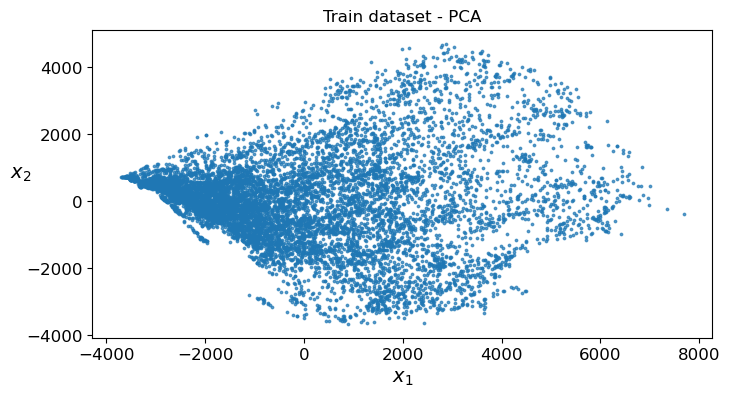

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca1 = pca.fit_transform(x_train, y_train)

plot_figure("Train dataset - PCA", X_pca1)

Preprocessed the train dataset by winsorizing and normalising the data.

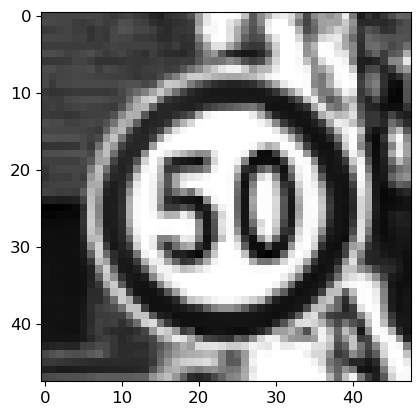

In [9]:
import matplotlib.pyplot as plt

img = x_train.iloc[4391]
img = img.values.reshape((48, 48))

plt.imshow(img, cmap='gray')
plt.show()

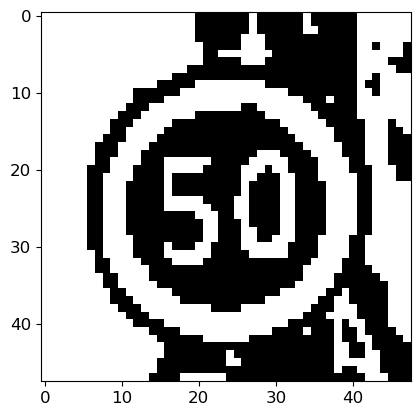

In [10]:
import cv2

ret, thresh1 = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY_INV)
plt.imshow(thresh1,cmap='gray')

In [11]:
threshold_value = 120
threshold_img_xtrain = "thresholded_images"

In [12]:
# Create the output folder if it doesn't exist
if not os.path.exists(threshold_img_xtrain):
    os.makedirs(threshold_img_xtrain)

# Loop through the dataset and apply thresholding
for i in range(len(x_train)):
    img = x_train.iloc[i].values.reshape((48, 48))
    ret, thresh1 = cv2.threshold(img, threshold_value, 255, cv2.THRESH_BINARY_INV)
    output_path = os.path.join(threshold_img_xtrain, f"thresholded_{i}.png")
    cv2.imwrite(output_path, thresh1)

In [13]:
thresholded_images = []
for i in range(len(x_train)):
    img_path = os.path.join(threshold_img_xtrain, f"thresholded_{i}.png")
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    thresholded_images.append(img)

x_train = np.array(thresholded_images)

In [14]:
from scipy.stats.mstats import winsorize

# Winsorize the data (adjust percentiles as needed)
winsorized_data = winsorize(x_train, limits=[0.05, 0.05])

def normalise(images):
    preprocessed_images = []
    for image in images: 
        if(len(image.shape) == 3):
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        if image.dtype != np.uint8:
            image = image.astype(np.uint8)

        adjusted = cv2.convertScaleAbs(image, alpha=0.5, beta = 10)
        enhanced_image = cv2.equalizeHist(adjusted)
        image = enhanced_image/255.0
        resize = cv2.resize(image, (48,48))

        preprocessed_images.append(resize)
    return  np.array(preprocessed_images)


x_train = normalise(x_train)

x_train = x_train.reshape(x_train.shape[0], -1)
x_train.shape

(9690, 2304)

In [15]:
#variance thresholdimg 

from sklearn.feature_selection import VarianceThreshold

# Set a threshold for variance (e.g., 0.1, but this value depends on your data)
threshold_value = 0.15

x_train = pd.DataFrame(x_train)
# Instantiate the VarianceThreshold object
selector = VarianceThreshold(threshold=threshold_value)

# Assuming 'df' is your dataset
# Fit the selector to the data
selector.fit(x_train)

# Get the indices of features to keep
features_to_keep = selector.get_support(indices=True)

# Create a new DataFrame with selected features
df_high_variance = x_train.iloc[:, features_to_keep]


x_train = np.asarray(df_high_variance)

In [16]:
features_to_keep

array([   0,    1,    2, ..., 2292, 2293, 2294], dtype=int64)

Plotted the clusters again using PCA and also plotted the clusters using t-SNE for exploration.

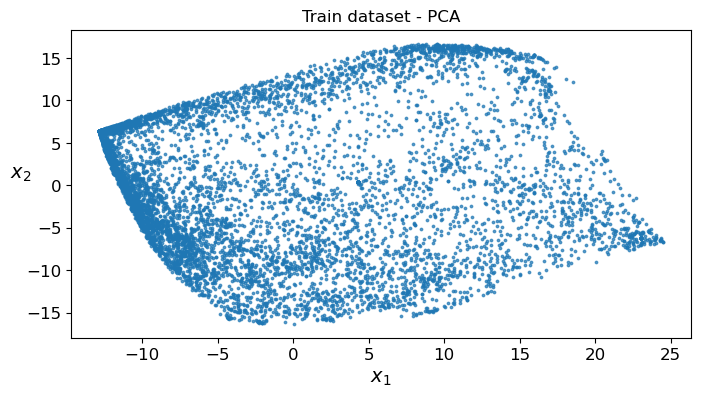

In [17]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca2 = pca.fit_transform(x_train, y_train)

plot_figure("Train dataset - PCA", X_pca2)

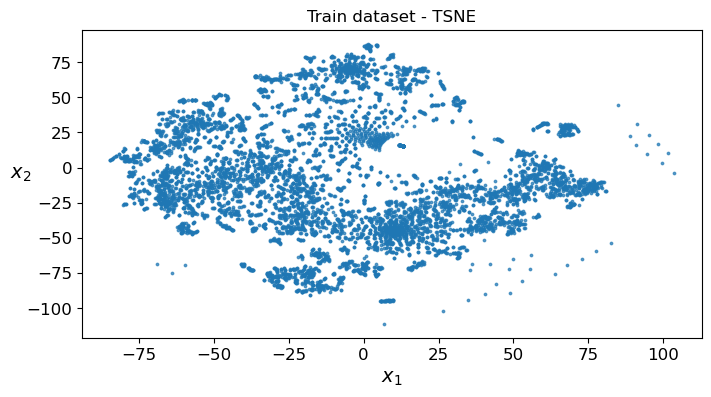

In [18]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
x_train_tsne = tsne.fit_transform(x_train)

plot_figure("Train dataset - TSNE", x_train_tsne)

Applied K-Means clusterer on the dataset and received the silhouette score. Used k = 10 at the start, i.e., 10 clusters.

In [19]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(x_train_scaled)

k = 10
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_pca)

In [20]:
tsne = TSNE(n_components=2, random_state=42)
x_train_tsne = tsne.fit_transform(x_train)

kmeans_tsne = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_labels_tsne = kmeans_tsne.fit_predict(x_train_tsne)

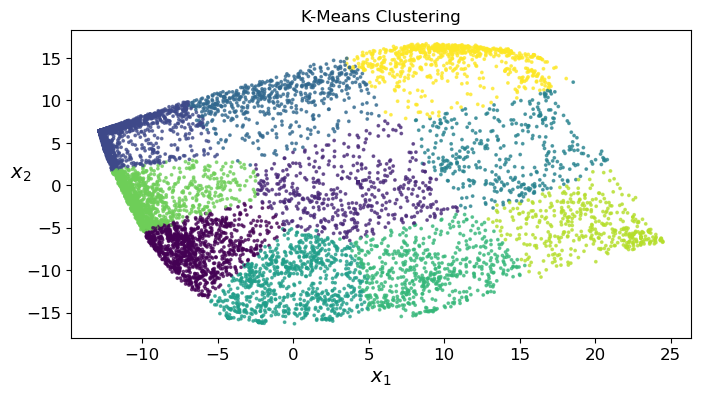

In [21]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca3 = pca.fit_transform(x_train)

plot_figure("K-Means Clustering", X_pca3, cluster_labels)

In [22]:
from sklearn.metrics import accuracy_score

def accuracy(c_labels, X, y_train, k, model):
    y_train = np.asarray(y_train)
    cl = model.fit_predict(X)

    for i in range(k):
        c = {}
        for j in range(len(c_labels)):
            if i == c_labels[j]:
                ground_truth_label = int(y_train[j])
                if ground_truth_label in c:
                    c[ground_truth_label] += 1
                else:
                    c[ground_truth_label] = 1
        max_c = max(c, key=c.get)
        for l in range(len(c_labels)):
            if i == c_labels[l]:
                cl[l] = max_c

    accuracy = accuracy_score(y_train, cl)  # Compare with ground truth labels
    print(f"Clustering Accuracy: {accuracy}")
    return accuracy

In [23]:
a1 = accuracy(cluster_labels, X_pca, y_train, k, kmeans)

Clustering Accuracy: 0.3153766769865841


In [24]:
a2 = accuracy(cluster_labels_tsne, x_train_tsne, y_train, k, kmeans_tsne)

Clustering Accuracy: 0.3570691434468524


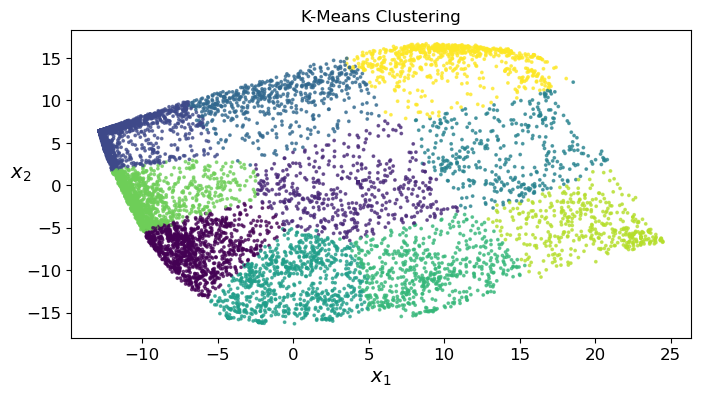

In [25]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca3 = pca.fit_transform(x_train)

plot_figure("K-Means Clustering", X_pca3, cluster_labels)

In [26]:
cluster_labels

array([1, 1, 1, ..., 3, 3, 3])

In [27]:
cluster_labels is kmeans.labels_

False

In [28]:
kmeans.inertia_

514289.7931375336

In [29]:
kmeans.cluster_centers_

array([[-1.68146373e+01, -1.64277240e+01],
       [ 1.02800814e+01,  8.63859683e-03],
       [-2.67253864e+01,  1.38789494e+01],
       [-1.95123218e+00,  2.35547048e+01],
       [ 3.46208462e+01,  8.48424552e+00],
       [-1.70483848e+00, -2.68945124e+01],
       [ 2.03650314e+01, -2.45252344e+01],
       [-2.32143602e+01, -2.40598877e+00],
       [ 4.72576418e+01, -1.26538895e+01],
       [ 2.66718043e+01,  3.35021296e+01]])

In [30]:
kmeans.labels_

array([4, 4, 4, ..., 3, 3, 3])

In [31]:
from sklearn.metrics import silhouette_score

silhouette_scores = silhouette_score(X_pca, cluster_labels)
print("Silhouette Score = ", silhouette_scores)

Silhouette Score =  0.5418970829711405


In [32]:
from sklearn.metrics import silhouette_score

silhouette_scores = silhouette_score(x_train_tsne, cluster_labels_tsne)
print("Silhouette Score = ", silhouette_scores)

Silhouette Score =  0.5136512


In [33]:
# Reference : https://colab.research.google.com/drive/1wq7JGYCT6Ctgd572KN9_QuIJwCS9tNo5?usp=sharing#scrollTo=7ZtUIKwNEcFS
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

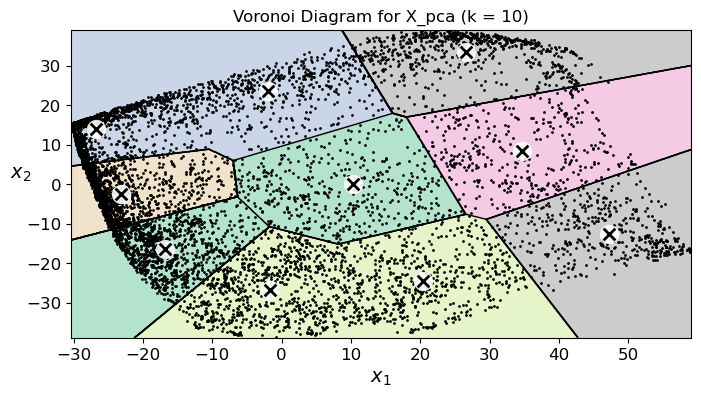

In [34]:
plt.figure(figsize=(8, 4))
plt.title("Voronoi Diagram for X_pca (k = 10)")
plot_decision_boundaries(kmeans, X_pca)
plt.show()

### 2) Hard & Soft Clustering

### 2.1) Hard Clustering

#### Heirarchical Clustering 

HC using PCA

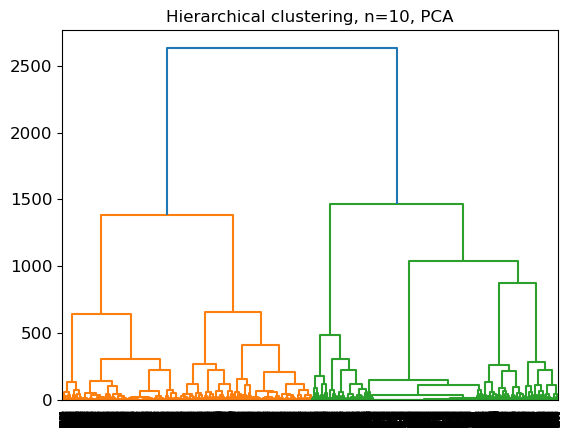

In [35]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

n_clusters=10
agg_clustering = AgglomerativeClustering(n_clusters=10)
agg_labels = agg_clustering.fit_predict(X_pca)

linkage_matrix = linkage(X_pca, method='ward')

dendrogram(linkage_matrix)
plt.title('Hierarchical clustering, n=10, PCA')
plt.show()

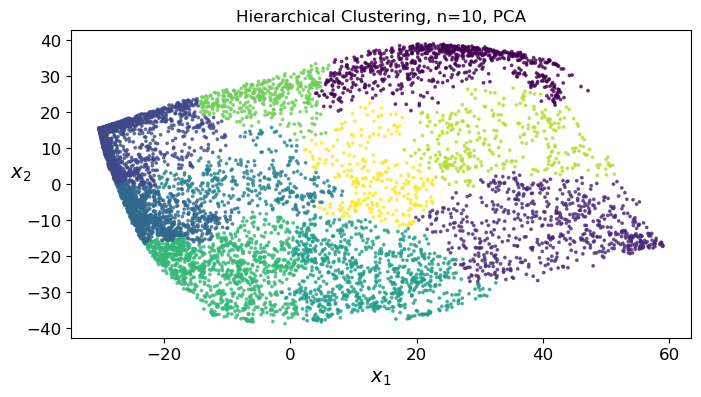

In [36]:
plt.figure(figsize=(8, 4))
plt.title("Hierarchical Clustering, n=10, PCA")
plot_clusters(X_pca, agg_labels)
plt.show()


Silhouette Score

In [37]:
from sklearn.metrics import silhouette_score

silhouette_scores = silhouette_score(X_pca, agg_labels)
print("Silhouette Score = ", silhouette_scores)

Silhouette Score =  0.5140855583063684


Accuracy

In [38]:
from sklearn.metrics import accuracy_score

def accuracy(c_labels, X, y_train, k):
    y_train = np.asarray(y_train)
    kmeans = AgglomerativeClustering(n_clusters=k)
    cl = kmeans.fit_predict(X)

    for i in range(k):
        c = {}
        for j in range(len(c_labels)):
            if i == c_labels[j]:
                ground_truth_label = int(y_train[j])
                if ground_truth_label in c:
                    c[ground_truth_label] += 1
                else:
                    c[ground_truth_label] = 1
        max_c = max(c, key=c.get)
        for l in range(len(c_labels)):
            if i == c_labels[l]:
                cl[l] = max_c

    accuracy = accuracy_score(y_train, cl)  # Compare with ground truth labels
    print(f"Clustering Accuracy: {accuracy}")
    return accuracy

In [39]:
a1 = accuracy(agg_labels, X_pca, y_train, 10)


Clustering Accuracy: 0.3240454076367389


HC using T-SNE

Silhouette Score with t-SNE + Heirarchical  =  0.4562487


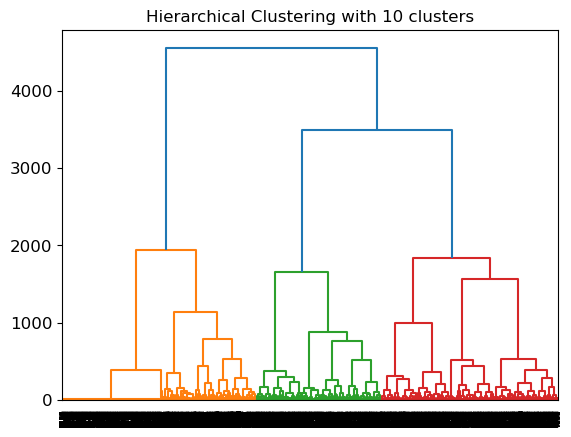

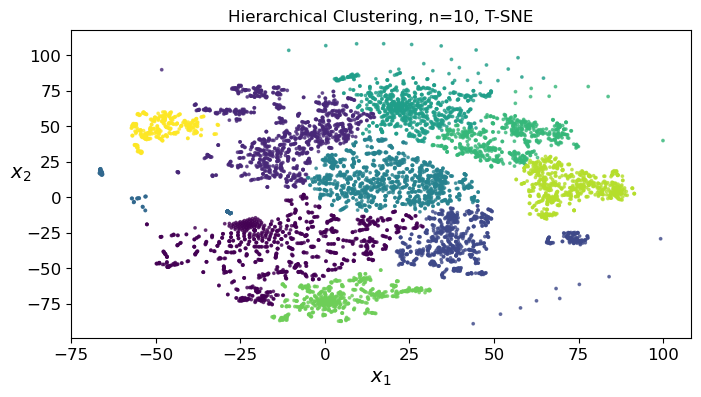

In [40]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)

tsne = TSNE(n_components=2, random_state=42)
x_train_tsne = tsne.fit_transform(x_train_scaled)

# Now apply K-means clustering on the t-SNE processed data
agg_clustering_tsne = AgglomerativeClustering(n_clusters=10)
agg_labels_tsne = agg_clustering_tsne.fit_predict(x_train_tsne)

silhouette_scores_tsne = silhouette_score(x_train_tsne, agg_labels_tsne)
print("Silhouette Score with t-SNE + Heirarchical  = ", silhouette_scores_tsne)

linkage_matrix = linkage(x_train_tsne, method='ward')

dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering with 10 clusters')
plt.show()

plt.figure(figsize=(8, 4))
plt.title("Hierarchical Clustering, n=10, T-SNE")
plot_clusters(x_train_tsne, agg_labels_tsne)
plt.show()

In [41]:
a2 = accuracy(agg_labels, x_train_tsne, y_train, 10)


Clustering Accuracy: 0.3240454076367389


### 2.2) Soft Clustering

#### Gausian Mixture Models Clustering

GMM using PCA

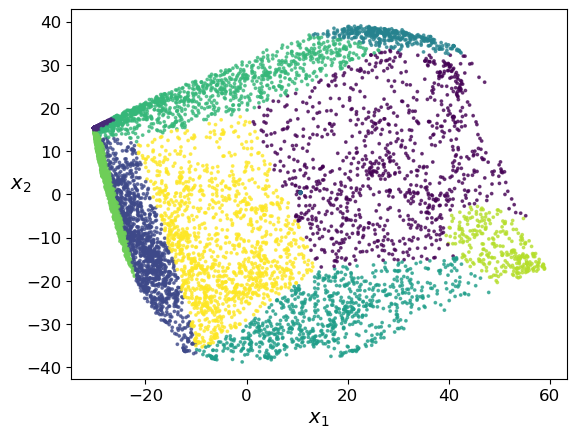

In [42]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=10)
gmm.fit(X_pca)

labels = gmm.predict(X_pca)

plot_clusters(X_pca, labels)


Silhouette Score

In [43]:
from sklearn.metrics import silhouette_score

silhouette_scores = silhouette_score(X_pca, labels)
print("Silhouette Score = ", silhouette_scores)

Silhouette Score =  0.2855063210400598


In [44]:
from sklearn.metrics import accuracy_score

def accuracy(c_labels, X, y_train, k):
    y_train = np.asarray(y_train)
    kmeans = GaussianMixture(n_components=k, random_state=42)
    cl = kmeans.fit_predict(X)

    for i in range(k):
        c = {}
        for j in range(len(c_labels)):
            if i == c_labels[j]:
                ground_truth_label = int(y_train[j])
                if ground_truth_label in c:
                    c[ground_truth_label] += 1
                else:
                    c[ground_truth_label] = 1
        max_c = max(c, key=c.get)
        for l in range(len(c_labels)):
            if i == c_labels[l]:
                cl[l] = max_c

    accuracy = accuracy_score(y_train, cl)  # Compare with ground truth labels
    print(f"Clustering Accuracy: {accuracy}")
    return accuracy

In [45]:
a3 = accuracy(labels, X_pca, y_train, 10)


Clustering Accuracy: 0.3331269349845201


GMM using T-SNE

Silhouette Score with t-SNE + GMM =  0.44516182


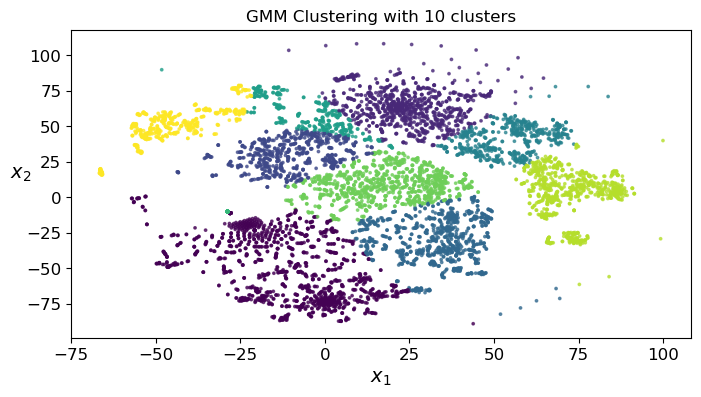

In [46]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)

tsne = TSNE(n_components=2, random_state=42)
x_train_tsne = tsne.fit_transform(x_train_scaled)

# Now apply K-means clustering on the t-SNE processed data
gmm = GaussianMixture(n_components=10)
gmm_labels_tsne = gmm.fit_predict(x_train_tsne)

silhouette_scores_tsne = silhouette_score(x_train_tsne, gmm_labels_tsne)
print("Silhouette Score with t-SNE + GMM = ", silhouette_scores_tsne)

plt.figure(figsize=(8, 4))
plt.title("GMM Clustering with 10 clusters")
plot_clusters(x_train_tsne, gmm_labels_tsne)
plt.show()

In [47]:
a4 = accuracy(gmm_labels_tsne, x_train_tsne, y_train, 10)


Clustering Accuracy: 0.365531475748194


In [48]:
def plot_agglomerative_decision_boundaries(agg, X, resolution=100, show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution), np.linspace(mins[1], maxs[1], resolution))
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    Z = agg.fit_predict(grid_points)
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap="Pastel2")
    plt.contour(xx, yy, Z, linewidths=1, colors='k')

    plot_data(X)
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)


In [49]:
def plot_gmm_decision_boundaries(clusterer, X, resolution=1000,
                                show_centroids=True, show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.fit_predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.means_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

In [50]:
import matplotlib.pyplot as plt

def plot_clusterer_comparison_spcase(clusterer1, clusterer2, X, title1=None, title2=None):
    plt.figure(figsize=(12, 4))

    plt.subplot(121)
    if isinstance(clusterer1, AgglomerativeClustering):
        plot_agglomerative_decision_boundaries(clusterer1, X)
    elif isinstance(clusterer1, GaussianMixture):
        plot_gmm_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    if isinstance(clusterer2, AgglomerativeClustering):
        plot_agglomerative_decision_boundaries(clusterer2, X, show_ylabels=False)
    elif isinstance(clusterer2, GaussianMixture):
        plot_gmm_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

    plt.tight_layout()


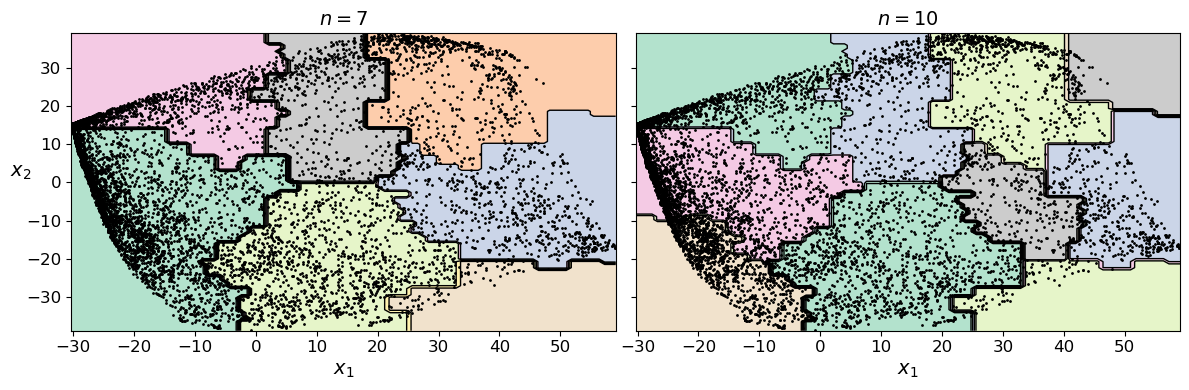

In [51]:
agg_n4 = AgglomerativeClustering(n_clusters=7)
agg_n10 = AgglomerativeClustering(n_clusters=10)

plot_clusterer_comparison_spcase(agg_n4, agg_n10, X_pca, "$n=7$", "$n=10$")
plt.show()

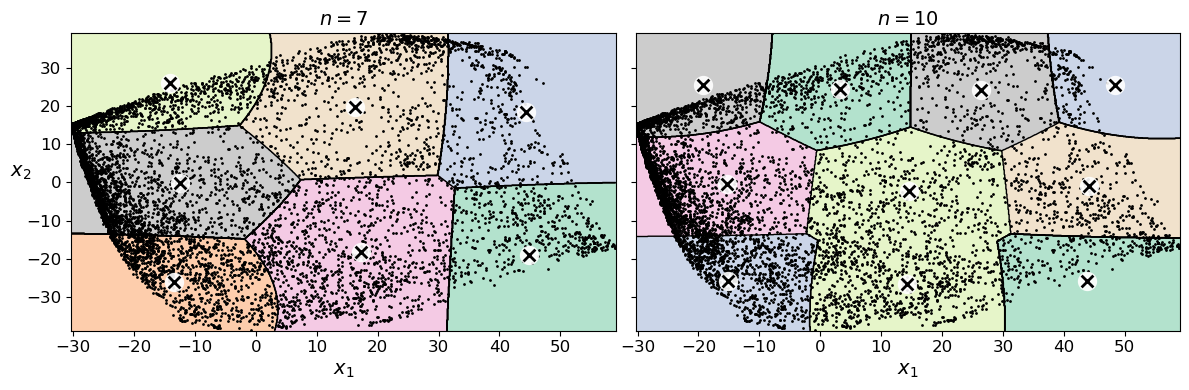

In [52]:
gmm_n7 = GaussianMixture(n_components=7, random_state=42)
gmm_n10 = GaussianMixture(n_components=10, random_state=42)

plot_clusterer_comparison_spcase(gmm_n7, gmm_n10, X_pca, "$n=7$", "$n=10$")
plt.show()

### 3) Determining Optimal Number of Clusters

In [53]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

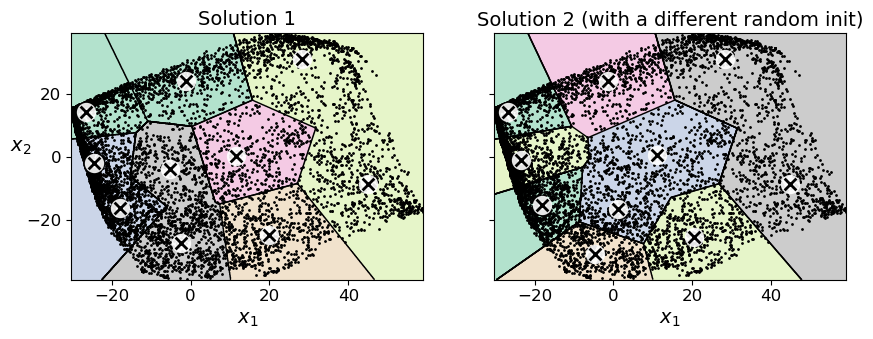

In [54]:
kmeans_rnd_init1 = KMeans(n_clusters=10, init="random", n_init=1,
                         algorithm="lloyd", random_state=44)
kmeans_rnd_init2 = KMeans(n_clusters=10, init="random", n_init=1,
                         algorithm="lloyd", random_state=50)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X_pca,
                          "Solution 1", "Solution 2 (with a different random init)")
plt.show()

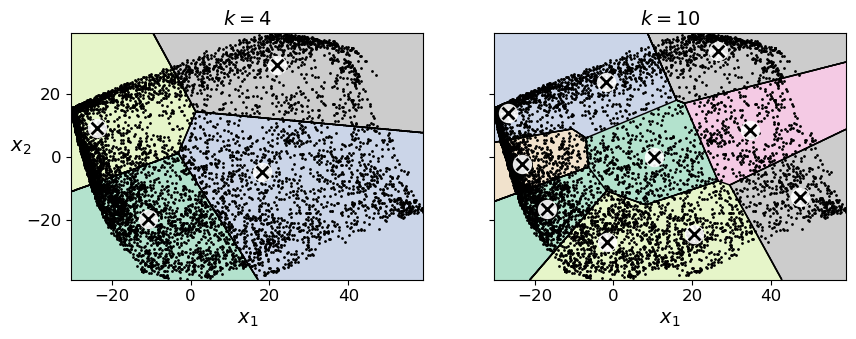

In [55]:
kmeans_k4 = KMeans(n_clusters=4, random_state=42, n_init=10)
kmeans_k10 = KMeans(n_clusters=10, random_state=42, n_init=10)

plot_clusterer_comparison(kmeans_k4, kmeans_k10, X_pca, "$k=4$", "$k=10$")
plt.show()

In [56]:
max_cluster=13
kmeans_per_k = [KMeans(n_clusters=k, random_state=42, n_init=10).fit(X_pca)
                for k in range(1, max_cluster)]
inertias = [model.inertia_ for model in kmeans_per_k]

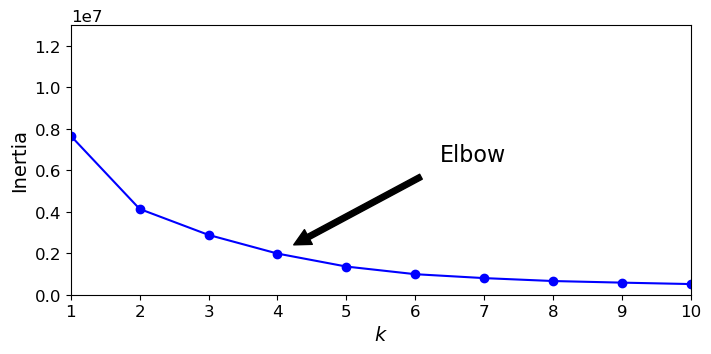

In [57]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, max_cluster), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 10, 0, 13000000])  # Adjust the y-axis limit as needed
plt.show()


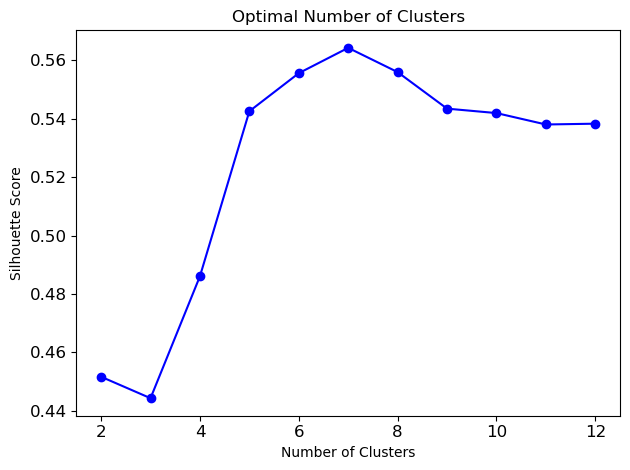

In [58]:
silhouette_scores = [silhouette_score(X_pca, model.labels_) for model in kmeans_per_k[1:]]     

plt.plot(range(2, max_cluster), silhouette_scores, "bo-")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Optimal Number of Clusters")
plt.tight_layout()
plt.show()